In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import cv2
from tensorflow import keras
from keras.layers import Dense
from keras.models import Sequential
import tensorflow as tf
import os
import shutil
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.datasets import cifar10
from keras.applications import VGG16
from tensorflow.keras.callbacks import LearningRateScheduler,EarlyStopping
from tensorflow.keras import optimizers
import tensorflow as tf
from tensorflow.keras.layers import Input, Conv2D, BatchNormalization, ReLU, Add, GlobalAveragePooling2D, Dense, Dropout
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from google.colab import files
from keras.utils import plot_model
from keras.models import load_model

In [ ]:
(x_train,y_train),(x_test,y_test) = cifar10.load_data()

170498071/170498071 ━━━━━━━━━━━━━━━━━━━━ 7s 0us/step


In [ ]:
x_train_split = []
y_train_split = []
x_validation_split = []
y_validation_split = []
for i in range(7000):
  x_validation_split.append(x_train[i])
  y_validation_split.append(y_train[i])

for j in range(7000,50000):
  x_train_split.append(x_train[j])
  y_train_split.append(y_train[j])

In [ ]:
x_train_split = np.array(x_train_split).astype("float32")
x_validation_split = np.array(x_validation_split).astype("float32")


y_train_split = keras.utils.to_categorical(y_train_split, 10)
y_validation_split = keras.utils.to_categorical(y_validation_split, 10)


valid_datagen = ImageDataGenerator(rescale=1./255)

train_datagen = ImageDataGenerator(
      rescale=1./255,
      rotation_range=20,
      width_shift_range=0.2,
      height_shift_range=0.2,
      shear_range=0.2,
      zoom_range=0.2,
      horizontal_flip=True,
      fill_mode='nearest')

train_generator = train_datagen.flow(
        # This is the target directory
        x_train_split,
        y_train_split,
        batch_size=40)

validation_generator = valid_datagen.flow(
        x_validation_split,
        y_validation_split,
        batch_size=40)

In [ ]:
def lr_schedule(epoch, lr):
    if epoch < 25:
        return lr
    elif epoch < 35:
        return lr * 0.1
    elif epoch < 45:
        return lr * 0.01
    else:
        return lr * 0.001

In [ ]:
# Define the building block of ResNet
def residual_block(x, filters, downsample=False):
    shortcut = x

    if downsample:
        # Adjust shortcut path if downsampling
        shortcut = Conv2D(filters, (1, 1), strides=(2, 2), padding='same')(shortcut)
        shortcut = BatchNormalization()(shortcut)

    x = Conv2D(filters, (3, 3), padding='same', strides=(2 if downsample else 1, 2 if downsample else 1))(x)
    x = BatchNormalization()(x)
    x = ReLU()(x)

    x = Conv2D(filters, (3, 3), padding='same')(x)
    x = BatchNormalization()(x)

    # Add the shortcut
    x = Add()([x, shortcut])
    x = ReLU()(x)
    return x

# Create the ResNet model
def create_resnet(input_shape=(32, 32, 3), num_classes=10):
    inputs = Input(shape=input_shape)

    # Initial Conv Layer
    x = Conv2D(64, (3, 3), padding='same')(inputs)
    x = BatchNormalization()(x)
    x = ReLU()(x)

    # Stacking residual blocks with downsampling
    for _ in range(5):
        x = residual_block(x, 64)

    for _ in range(5):
        x = residual_block(x, 128, downsample=True)  # Downsample when increasing filters

    for _ in range(5):
        x = residual_block(x, 256, downsample=True)  # Downsample when increasing filters

    # Global average pooling and output layer
    x = GlobalAveragePooling2D()(x)
    x = Dropout(0.5)(x)  # Dropout for regularization
    outputs = Dense(num_classes, activation='softmax')(x)

    model = Model(inputs=inputs, outputs=outputs)
    return model

# Instantiate and compile the model
model = create_resnet()
model.compile(optimizer=Adam(learning_rate=0.001), loss='categorical_crossentropy', metrics=['accuracy'])

# Print model summary
model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)  │ (None, 32, 32, 3)      │              0 │ -                      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d (Conv2D)           │ (None, 32, 32, 64)     │          1,792 │ input_layer[0][0]      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization       │ (None, 32, 32, 64)     │            256 │ conv2d[0][0]           │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ re_lu (ReLU)              │ (None, 32, 32, 64)     │              0 │ batch_normalization[0… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_1 (Conv2D)         │ (None, 32, 32, 64)     │         36,928 │ re_lu[0][0]            │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_1     │ (None, 32, 32, 64)     │            256 │ conv2d_1[0][0]         │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ re_lu_1 (ReLU)            │ (None, 32, 32, 64)     │              0 │ batch_normalization_1… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_2 (Conv2D)         │ (None, 32, 32, 64)     │         36,928 │ re_lu_1[0][0]          │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_2     │ (None, 32, 32, 64)     │            256 │ conv2d_2[0][0]         │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ add (Add)                 │ (None, 32, 32, 64)     │              0 │ batch_normalization_2… │
│                           │                        │                │ re_lu[0][0]            │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ re_lu_2 (ReLU)            │ (None, 32, 32, 64)     │              0 │ add[0][0]              │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_3 (Conv2D)         │ (None, 32, 32, 64)     │         36,928 │ re_lu_2[0][0]          │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_3     │ (None, 32, 32, 64)     │            256 │ conv2d_3[0][0]         │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ re_lu_3 (ReLU)            │ (None, 32, 32, 64)     │              0 │ batch_normalization_3… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_4 (Conv2D)         │ (None, 32, 32, 64)     │         36,928 │ re_lu_3[0][0]          │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_4     │ (None, 32, 32, 64)     │            256 │ conv2d_4[0][0]         │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ add_1 (Add)          

 Total params: 7,778,058 (29.67 MB)

 Trainable params: 7,765,130 (29.62 MB)

 Non-trainable params: 12,928 (50.50 KB)

In [ ]:
history = model.fit(
    train_generator,
    epochs=70,
    validation_data=validation_generator,
    verbose=2
)


Epoch 1/70


/usr/local/lib/python3.10/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


1075/1075 - 96s - 89ms/step - accuracy: 0.2693 - loss: 2.0724 - val_accuracy: 0.3824 - val_loss: 1.6619
Epoch 2/70
1075/1075 - 49s - 46ms/step - accuracy: 0.3898 - loss: 1.6783 - val_accuracy: 0.4711 - val_loss: 1.4480
Epoch 3/70
1075/1075 - 49s - 46ms/step - accuracy: 0.4643 - loss: 1.4891 - val_accuracy: 0.4061 - val_loss: 1.8707
Epoch 4/70
1075/1075 - 49s - 45ms/step - accuracy: 0.5170 - loss: 1.3557 - val_accuracy: 0.5811 - val_loss: 1.1751
Epoch 5/70
1075/1075 - 83s - 77ms/step - accuracy: 0.5620 - loss: 1.2464 - val_accuracy: 0.5630 - val_loss: 1.2515
Epoch 6/70
1075/1075 - 82s - 76ms/step - accuracy: 0.6010 - loss: 1.1460 - val_accuracy: 0.5280 - val_loss: 1.5787
Epoch 7/70
1075/1075 - 82s - 76ms/step - accuracy: 0.6327 - loss: 1.0663 - val_accuracy: 0.6017 - val_loss: 1.1638
Epoch 8/70
1075/1075 - 83s - 77ms/step - accuracy: 0.6607 - loss: 0.9923 - val_accuracy: 0.6956 - val_loss: 0.8847
Epoch 9/70
1075/1075 - 81s - 75ms/step - accuracy: 0.6818 - loss: 0.9344 - val_accuracy: 0.

In [ ]:
# Define the path to your local folder
local_folder_path = './my_model.keras'
model.save(local_folder_path)


In [ ]:
files.download('my_model.keras')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
corrects = 0
block = 0
for id,image in enumerate (x_test):
  img = image
  img_array = np.array(img)
  img_array = np.expand_dims(img_array, axis=0)  # Add batch dimension
  # Normalize the images if you did so during training
  img_array = img_array.astype('float32') / 255.0  # Example normalization
  # Step 3: Make predictions
  predictions = model.predict(img_array)
  predicted_classes = np.argmax(predictions, axis=1)
  if(predicted_classes == y_test[id][0]):
    corrects+=1
  block += 1
  if(block >= 1000):
    break

print("The accuracy of tests is: ",corrects/block)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━

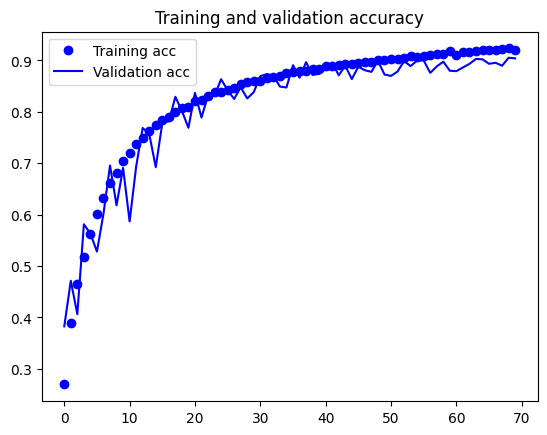

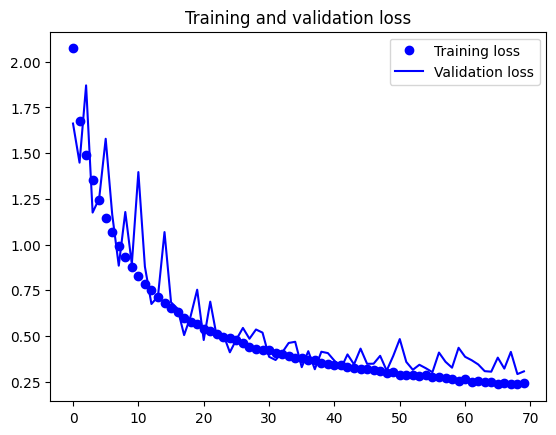

In [ ]:
%matplotlib inline
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

In [ ]:
plot_model(model, to_file='cnn_model.png', show_shapes=True, show_layer_names=True)

InvocationException: Program terminated with status: -6. stderr follows: newtrap: Trapezoid-table overflow 2661
dot: trapezoid.c:84: newtrap: Assertion `0' failed.


In [ ]:
corrects = 0
block = 0
for id,image in enumerate (x_test):
  img = image
  img_array = np.array(img)
  img_array = np.expand_dims(img_array, axis=0)  # Add batch dimension
  # Normalize the images if you did so during training
  img_array = img_array.astype('float32') / 255.0  # Example normalization
  # Step 3: Make predictions
  predictions = model.predict(img_array)
  predicted_classes = np.argmax(predictions, axis=1)
  if(predicted_classes == y_test[id][0]):
    corrects+=1
  block += 1
  if(block >= 1000):
    break

print("The accuracy of tests is: ",corrects/block)

NameError: name 'x_test' is not defined

In [ ]:
import os
model_path = os.path.abspath('my_model.keras')
model = load_model(model_path)


OSError: [Errno 22] Invalid argument

In [ ]:
!ls

my_model.keras	sample_data
